In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2


In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D')
fig_dir = os.path.join(output_dir, 'figures')
lr = 0.0005
max_epoch = 30000
roi_list = ['V1','V2','V3']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
ARGS_2D = ['sub','lr','eph','roi']
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in  [3,2,0]]
roi_pal.insert(0, (0.3,0.3,0.3))
stim_classes=['annulus', 'pinwheel', 'forward spiral','reverse spiral']

# Predict synthetic data based on the model parameters

```python
stim_info='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsdsyn_stim_description.csv'
stim_info = vis2D.get_w_a_and_w_r_for_each_stim_class(stim_info)

ecc_range = (0, 12)
n_ecc = 121
angle_range = (np.deg2rad(0), np.deg2rad(360))
n_angle = 360
ecc_col = 'eccentricity'
angle_col = 'angle'
synthetic_df = vis2D.make_synthetic_dataframe_for_2D(stim_info,
                                                ecc_range, n_ecc,
                                                angle_range, n_angle,
                                                ecc_col, angle_col)

synthetic_df['local_ori'] = prep.calculate_local_orientation(w_a = synthetic_df['w_a'],
                                                     w_r = synthetic_df['w_r'],
                                                     retinotopic_angle=synthetic_df[angle_col],
                                                     angle_in_radians=True,
                                                     reference_frame='relative')

synthetic_df['local_ori'] = prep.calculate_local_orientation(w_a = synthetic_df['w_a'],
                                                     w_r = synthetic_df['w_r'],
                                                     retinotopic_angle=synthetic_df[angle_col],
                                                     angle_in_radians=True,
                                                     reference_frame='relative')

synthetic_df['Pv'] = synthetic_df.apply(model.get_Pv_row, 
                                        params=final_params.query('sub == "subj01" & vroinames == "V1"'), 
                                        axis=1)



# Load models

In [3]:
pt_file_list = []
for subj, roi in itertools.product(nsd_subj_list, roi_list):
    file_name = os.path.join(output_dir, 'sfp_model', 'results_2D', 'nsdsyn', 'corrected',
                             f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

nsd_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision', f'precision-s_dset-nsdsyn_vs-pRFsize.csv'))
nsd_df = pd.merge(nsd_params, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])


In [4]:
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_params = nsd_df

# Load synthetic data

In [5]:
pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
for subj, roi, frame in itertools.product(nsd_subj_list, roi_list, ['scaled','constant']):
    file_name = os.path.join(output_dir, 'sfp_model', 'prediction_2D', 'nsdsyn', 'corrected',
                             f'sfstimuli-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
nsd_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D+['sfstimuli'])

nsd_df = pd.merge(nsd_prediction, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

In [6]:
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_df = nsd_df

# Plot each parameter and prediction

## Bandwidth and predicted tuning curves

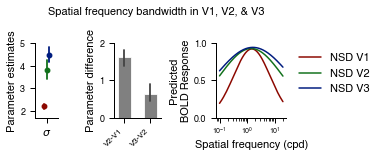

In [7]:
local_ori = np.deg2rad(90)
ecc = 5
angle = np.deg2rad(180)
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'extension')
weighted_mean_df = vis2D.get_weighted_average_of_params(tmp, ['dset_type'], ecc, angle, local_ori)

fig, axes = vis2D.plot_param_hierarchy_and_prediction(params_df=tmp, params=['sigma'], 
                                            hue='dset_type', hue_order=hue_order,
                                            prediction_df=weighted_mean_df, prediction_y=None,
                                            pal=pal,
                                            params_ylim=(1.7, 5), params_yticks=[2, 3,4,5],
                                            prediction_ylim=None, prediction_yticks=None,
                                            title='Spatial frequency bandwidth in V1, V2, & V3',
                                            prediction_ylabel='Preferred period (deg)',
                                            hierarchy_ylim=[0,2], hierarchy_yticks=[0,1,2],
                                            figsize=(4.5, 1.8), width_ratios=[1, 2, 3], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'extension', 'param-bandwidth_goal-extension_lr-0.0005_eph-30000_vs-pRFsize.svg'))

## slope and intercept

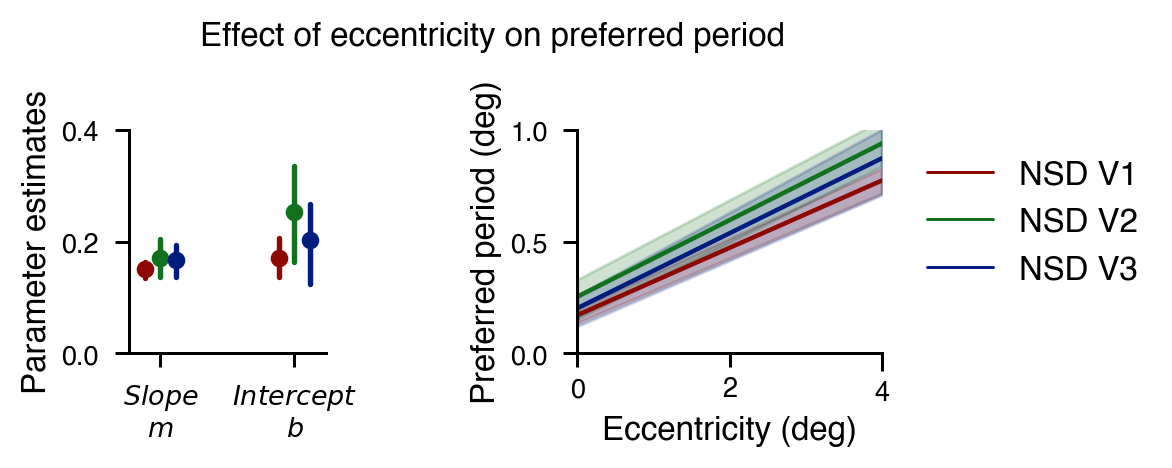

In [8]:
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'extension')

ecc_list=[0,4]
ecc_df = ecc_df.query('sfstimuli == "scaled" & eccentricity in @ecc_list')
ecc_df = ecc_df.groupby(['sub','dset_type','vroinames','eccentricity']).mean().reset_index()

fig, axes = vis2D.plot_param_and_prediction(params_df=tmp, params=['slope','intercept'], 
                                            hue='dset_type', hue_order=hue_order,
                                            prediction_df=ecc_df, prediction_y='Pv',
                                            pal=pal,
                                            params_ylim=(0, 0.4), params_yticks=[0, 0.2, 0.4],
                                            prediction_ylim=(0,1), prediction_yticks=[0,0.5,1],
                                            xlim=(0,4), xticks=[0,2,4],
                                            prediction_ylabel='Preferred period (deg)',
                                            figsize=(4.5, 1.8), width_ratios=[1.3,2], 
                                            
                                            title='Effect of eccentricity on preferred period',
                                            save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'extension', 'param-ecceffect_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))



# Plot preferred period for each parameter

## P1: Horizontal gratings vs. vertical gratings

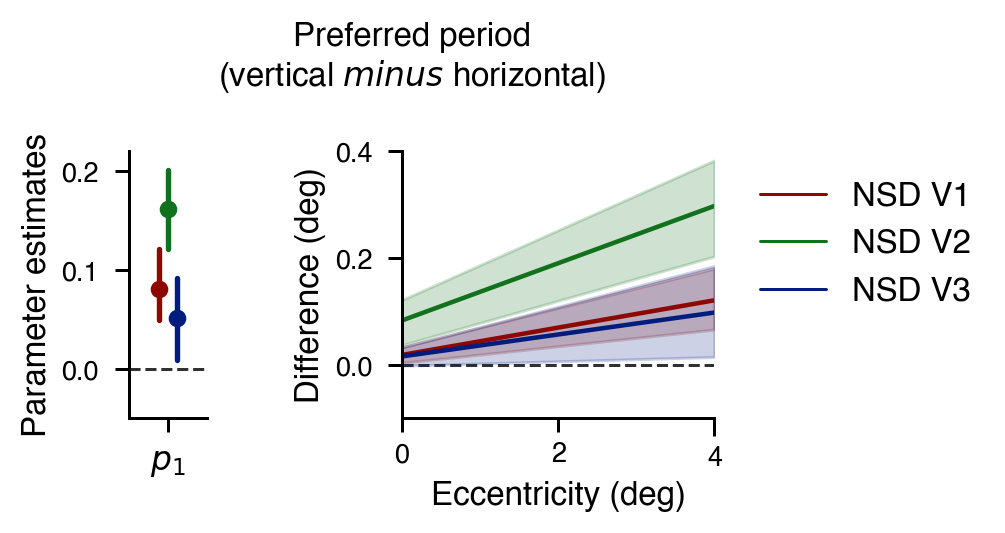

In [9]:
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'extension')
ecc_df = ecc_df.query('sfstimuli == "constant"')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'vertical', 'horizontal', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

fig, axes = vis2D.plot_param_and_prediction(params_df=tmp, params=['p_1'], 
                                              params_ylim=(-0.05, 0.22), params_yticks= [0,0.1,0.2], 
                                              prediction_df=p_df, prediction_y='Pv_diff',
                                              prediction_ylim=(-0.1, 0.4), prediction_yticks= [0,0.2,0.4],         
                                              xlim=(0,4), xticks=[0,2,4],
                                              pal=pal, hue='dset_type', hue_order=hue_order,
                                              prediction_ylabel= 'Difference (deg)',
                                              title='Preferred period\n(vertical ''$\it{minus}$' ' horizontal)',
                                              figsize=(3.5, 2.15), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'extension','param-p1_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))


## P2: cardinal vs. oblique

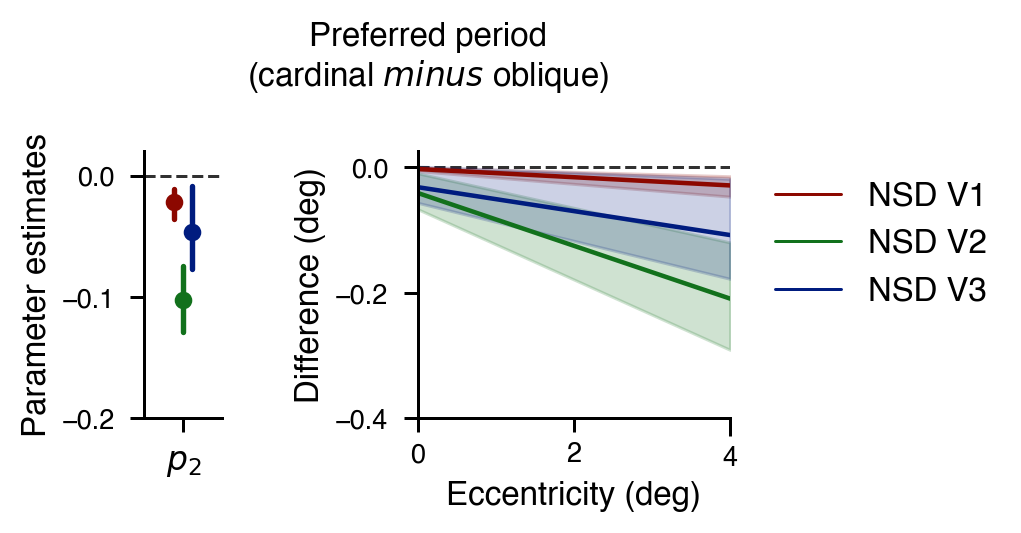

In [10]:
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'extension')
ecc_df = ecc_df.query('eccentricity in @ecc_list')
ecc_df = ecc_df.query('sfstimuli == "constant"')

p_df = vis2D.get_Pv_difference(ecc_df, 'cardinal', 'oblique', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

fig, axes = vis2D.plot_param_and_prediction(params_df=tmp, params=['p_2'], 
                          params_ylim=(-0.2, 0.02), params_yticks= [-0.2,-0.1,0,], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.4, 0.025), prediction_yticks= [-0.4,-0.2,0],            xlim=(0,4), xticks=[0,2,4],
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(cardinal ''$\it{minus}$' ' oblique)',
                          figsize=(3.5, 2.15), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'extension','param-p2_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))

## P3: Annulus vs. pinwheel

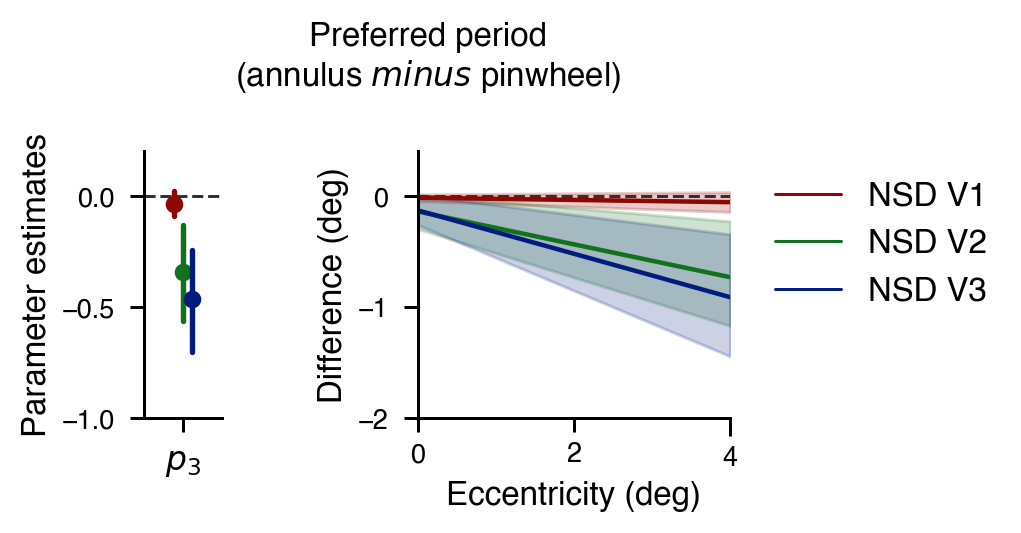

In [12]:
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'extension')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'annulus', 'pinwheel', 
                               to_group=['sub', 'eccentricity', 'dset_type','vroinames'], orientation_col='names')

fig, axes =vis2D.plot_param_and_prediction(params_df=tmp, params=['p_3'], 
                          params_ylim=(-1, 0.2), params_yticks= [-1,-0.5,0], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-2, 0.4), prediction_yticks= [-2,-1,0],            
                          xlim=(0,4), xticks=[0,2,4],
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(annulus ''$\it{minus}$' ' pinwheel)',
                          figsize=(3.5, 2.15), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'extension','param-p3_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))


In [ ]:
plotted_items = ['NSD V1', 'NSD V2', 'NSD V3']
for i, dset in enumerate(plotted_items):
    print( f'{dset} mean:', np.round(axes[0].lines[i*len(plotted_items)].get_xydata()[0][1], 3))
    low_ci = np.round(axes[0].lines[i*len(plotted_items)+1].get_xydata()[0,1], 3)
    high_ci = np.round(axes[0].lines[i*len(plotted_items)+1].get_xydata()[1,1], 3)
    ci = np.round((high_ci - low_ci)/2, 3)
    print(f'{dset} 68% CI: {ci} ({low_ci}, {high_ci})')

## P4: Spirals vs. annulus/pinwheel

(<Figure size 756x464.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:xlabel='Eccentricity (deg)', ylabel='Difference (deg)'>],
       dtype=object))

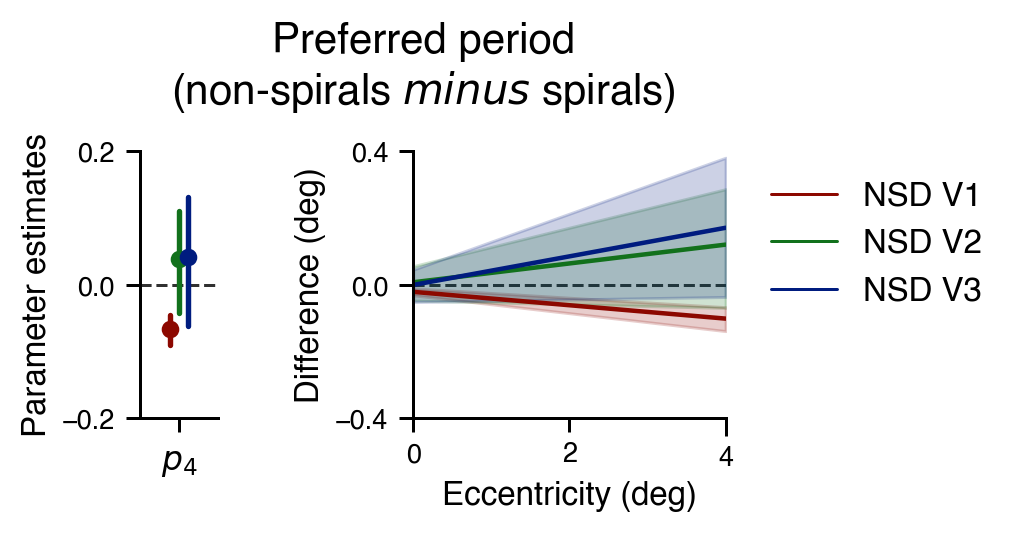

In [13]:
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'extension')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'non-spirals', 'spirals', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_4'], 
                          params_ylim=(-0.2, 0.2), params_yticks= [-0.2,0,0.2], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.4, 0.4), prediction_yticks= [-0.4,0,0.4],            xlim=(0,4), xticks=[0,2,4],
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(non-spirals ''$\it{minus}$' ' spirals)',
                          figsize=(3.5, 2.15), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'extension','param-p4_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))

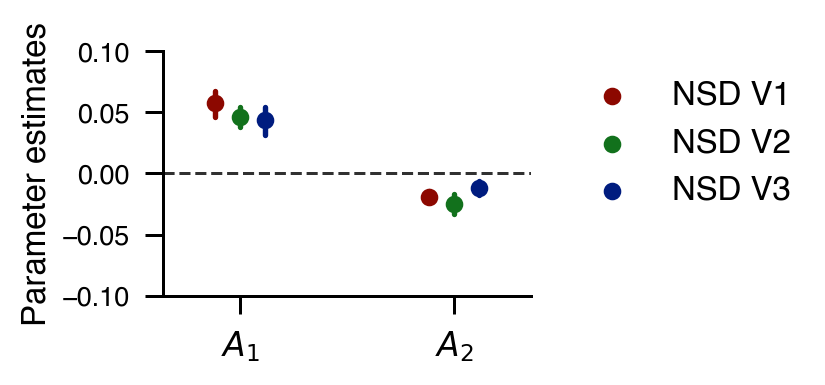

In [42]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'extension')

fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.5),
                         sharey=False, sharex=False)

g = vis2D.plot_precision_weighted_avg_parameter(tmp, ['A_1', 'A_2'], 'dset_type', hue_order, ax=ax, ylim=(-0.1,0.1), yticks=[-0.1,-0.05,0,0.05,0.1], pal=pal)
g.margins(x=0.2)
g.legend(bbox_to_anchor=(1.05, 1), loc='best', frameon=False)
utils.save_fig(os.path.join(fig_dir, 'sfp_model', 'results_2D', 'extension','param-A12_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))

In [45]:
for p in g.lines:
    xy = p.get_xydata()
    color = p.get_color()
    print(f'xy: {xy}')


xy: [[-0.115       0.05758915]
 [ 0.885      -0.01937496]]
xy: [[-0.115       0.04584893]
 [-0.115       0.06753371]]
xy: [[ 0.885      -0.02289781]
 [ 0.885      -0.01470068]]
xy: [[ 0.          0.04642607]
 [ 1.         -0.02496658]]
xy: [[0.         0.03800659]
 [0.         0.05389585]]
xy: [[ 1.         -0.03311902]
 [ 1.         -0.01678892]]
xy: [[ 0.115      0.0439574]
 [ 1.115     -0.0123464]]
xy: [[0.115      0.03175902]
 [0.115      0.05453335]]
xy: [[ 1.115      -0.01731859]
 [ 1.115      -0.00657294]]
xy: [[0. 0.]
 [1. 0.]]


# Summary: weighted average of parameters

In [16]:
PARAMS_2D = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']
utils.calculate_weighted_mean(tmp, PARAMS_2D, 'precision', groupby=['dset_type'])

,dset_type,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2
0,NSD V1,2.199299,0.150471,0.171367,0.080991,-0.021897,-0.036557,-0.065930,0.057589,-0.019375
1,NSD V2,3.797996,0.171325,0.253642,0.161812,-0.102574,-0.342089,0.039329,0.046426,-0.024967
2,NSD V3,4.461167,0.167584,0.202358,0.051839,-0.046833,-0.463685,0.042397,0.043957,-0.012346


(<Figure size 1857.6x324 with 5 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

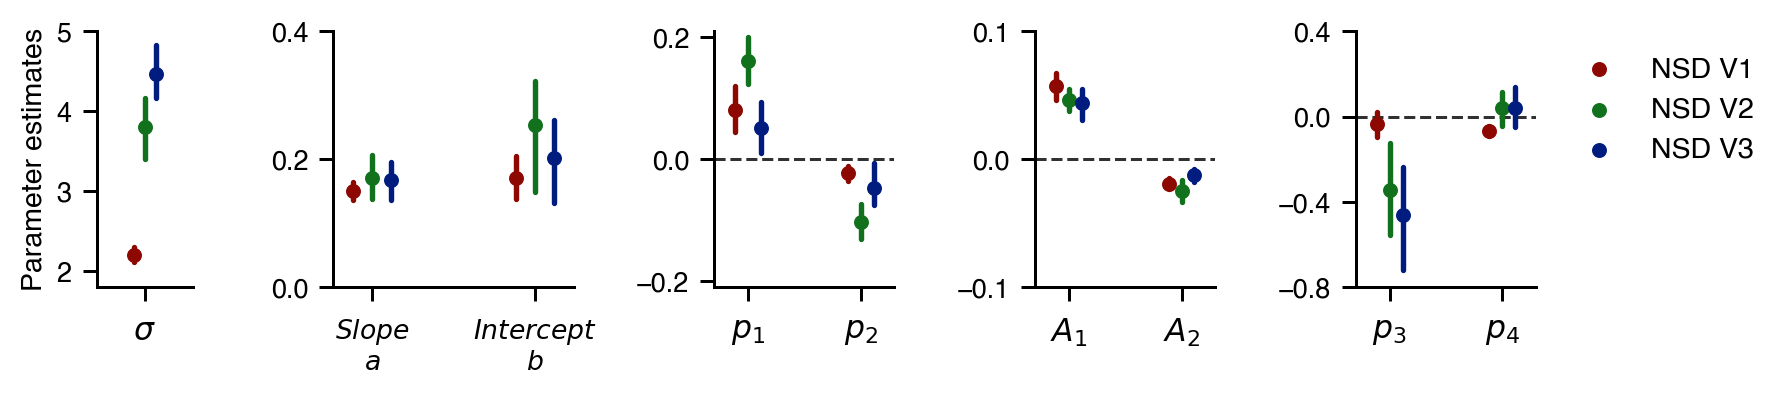

In [19]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'extension')
ylim_list = [(1.8, 5), (0, 0.4), (-0.21, 0.21),  (-0.1,0.1), (-0.8, 0.4)]
yticks_list=  [[2,3,4,5], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.1,0,0.1],[-0.8,-0.4,0,0.4]]
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1','A_2'], ['p_3','p_4']]
title_list = ['Bandwidth', 'Eccentricity effect', 'Absolute orientation effect\non preferred period', 'Amplitude', 'Relative orientation effect\non preferred period']
vis2D.make_param_summary_fig(tmp, 'dset_type', hue_order, pal, 
                           params_list, ylim_list, yticks_list, title_list=None,
                           width_ratios=(0.8,2,1.5,1.5,1.5), fig_size=(8.6, 1.5),
                           scale=0.85,
                           save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'extension','summary_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))
#g.margins(x=0.1)

In [15]:
for p in ax.lines:
    xy = p.get_xydata()
    print(xy)
    print(p)

[[-0.115       0.05758915]
 [ 0.885      -0.01937496]]
Line2D(_child0)
[[-0.115       0.04625097]
 [-0.115       0.06669439]]
Line2D(_child1)
[[ 0.885      -0.0237973 ]
 [ 0.885      -0.01486062]]
Line2D(_child2)
[[ 0.          0.04642607]
 [ 1.         -0.02496658]]
Line2D(_child4)
[[0.         0.0371302 ]
 [0.         0.05357586]]
Line2D(_child5)
[[ 1.         -0.03283093]
 [ 1.         -0.01672312]]
Line2D(_child6)
[[ 0.115      0.0439574]
 [ 1.115     -0.0123464]]
Line2D(_child8)
[[0.115      0.03142318]
 [0.115      0.05515957]]
Line2D(_child9)
[[ 1.115      -0.01685555]
 [ 1.115      -0.00645285]]
Line2D(_child10)
[[0. 0.]
 [1. 0.]]
Line2D(_child12)
